# Home Cage| Sanbox Analysis

Answering random questions

In [1]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

from trial_class import *
from experiment_class import Experiment
from bouts_extension import *
from hc_extension import *

In [2]:
# NAc: #15616F
# mPFC: #FFAF00

# NAc
# experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\nac"
# csv_base_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\nac_csvs"
# brain_region = '#15616F'

# mPFC
experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\mpfc"
csv_base_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\mpfc_csvs"
brain_region = '#FFAF00'

In [3]:
bout_definitions = [
    {'prefix': 'Short_Term', 'introduced': 'Short_Term_Introduced', 'removed': 'Short_Term_Removed'},
    {'prefix': 'Long_Term', 'introduced': 'Long_Term_Introduced', 'removed': 'Long_Term_Removed'},
    {'prefix': 'Novel', 'introduced': 'Novel_Introduced', 'removed': 'Novel_Removed'}
]


In [4]:
# groups csv + experiment data into one variable
experiment = Experiment(experiment_path, csv_base_path)

# batch process the data, removing the specified time segments for subjects
experiment.default_batch_process()

Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\mpfc\p1-240508-084607\Notes.txt
read from t=0s to t=1812.36s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\mpfc\p2-240508-101128\Notes.txt
read from t=0s to t=1820.76s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\mpfc\p3-240509-070801\Notes.txt
read from t=0s to t=1818.93s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\mpfc\p5-240823-093250\Notes.txt
read from t=0s to t=1794.17s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\mpfc\p6-240823-105552\Notes.txt
read from t=0s to t=1807.06s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\mpfc\p7-240824-053845\Notes.txt
rea

### Check if there is a second behavioral event when you take the peak nearest to first investigation. We want to ensure you are not taking the peak of a second behavioral event.

In [5]:
experiment.reset_all_behaviors()
experiment.group_extract_manual_annotations(bout_definitions=bout_definitions, first_only = False)

# total_avg_bout_duration = metadata_df["Average Bout Duration"].mean()
# print(f"Total Average Bout Duration: {total_avg_bout_duration:.4f}")
# Proceed with DA metric computation after all files are processed
experiment.compute_all_da_metrics(use_max_length=False,
                                  max_bout_duration=4, # total_avg_bout_duration 
                                  mode='standard')

Processing behaviors for p1-240508-084607...
Processing behaviors for p2-240508-101128...
Processing behaviors for p3-240509-070801...
Processing behaviors for p5-240823-093250...
Processing behaviors for p6-240823-105552...
Processing behaviors for p7-240824-053845...
Processing behaviors for p8-240824-070451...
Processing behaviors for pp1-250120-094415...
Processing behaviors for pp2-250121-123301...
Processing behaviors for pp3-250121-055222...
Processing behaviors for pp4-250121-065035...
Processing behaviors for pp5-250121-110144...
Processing behaviors for pp6-250121-114116...
Processing behaviors for pp7-250121-134131...
Processing behaviors for pp8-250121-142227...
Computing DA metrics for p1-240508-084607 ...
Computing DA metrics for p2-240508-101128 ...
Computing DA metrics for p3-240509-070801 ...
Computing DA metrics for p5-240823-093250 ...
Computing DA metrics for p6-240823-105552 ...
Computing DA metrics for p7-240824-053845 ...
Computing DA metrics for p8-240824-070451

In [6]:
exp_da_dict = get_trial_dataframes(experiment)
desired_bouts = ['s1-1', 's1-2', 's1-3', 's1-4', 's1-5', 's2-1']

In [7]:
def count_peaks_past_next_investigation(exp_da_dict, behavior="Investigation"):
    """
    For each subject and bout, check if the first behavior's peak occurs
    after the second behavior's onset. Returns a nested dict:
    
    {
      subject_id: {
        bout_label: {
          "overlap": True/False,
          "absolute_peak_time": float,
          "second_onset": float
        },
        ...
      },
      ...
    }
    """
    from collections import defaultdict

    overlaps = defaultdict(dict)

    for subj, df in exp_da_dict.items():
        df_b = df[df["Behavior"] == behavior].copy()
        df_b.sort_values("Event_Start", inplace=True)

        for bout, g in df_b.groupby("Bout"):
            g = g.reset_index(drop=True)

            if len(g) < 2:
                overlaps[subj][bout] = {
                    "overlap": False,
                    "absolute_peak_time": None,
                    "second_onset": None
                }
                continue

            first = g.loc[0]
            second_onset = g.loc[1, "Event_Start"]
            absolute_peak_time = first["Event_Start"] + first["Time of Max Peak"]

            overlaps[subj][bout] = {
                "overlap": absolute_peak_time > second_onset,
                "absolute_peak_time": absolute_peak_time,
                "second_onset": second_onset
            }

    return overlaps


In [8]:
overlaps = count_peaks_past_next_investigation(exp_da_dict)

In [9]:
for subj, bouts in overlaps.items():
    for bout, info in bouts.items():
        if info["overlap"]:
            print(f"⚠️ {subj} / {bout}: 1st peak ({info['absolute_peak_time']:.2f}s) ≥ 2nd onset ({info['second_onset']:.2f}s)")


In [10]:
# exp_da_dict['nn6']

### Run anova for order effects in 3 agent experiment: DA

In [11]:
experiment.reset_all_behaviors()
experiment.group_extract_manual_annotations(bout_definitions, first_only=False)
experiment.compute_all_da_metrics(max_bout_duration=4, 
                                  mode='standard')
exp_da_dict = get_trial_dataframes(experiment)
desired_bouts = ['Short_Term-1', 'Novel-1', 'Short_Term-2', 'Long_Term-1']
da_metadata_df = create_da_metrics_first_instance(exp_da_dict, behavior="Investigation", desired_bouts=desired_bouts)

Processing behaviors for p1-240508-084607...
Processing behaviors for p2-240508-101128...
Processing behaviors for p3-240509-070801...
Processing behaviors for p5-240823-093250...
Processing behaviors for p6-240823-105552...
Processing behaviors for p7-240824-053845...
Processing behaviors for p8-240824-070451...
Processing behaviors for pp1-250120-094415...
Processing behaviors for pp2-250121-123301...
Processing behaviors for pp3-250121-055222...
Processing behaviors for pp4-250121-065035...
Processing behaviors for pp5-250121-110144...
Processing behaviors for pp6-250121-114116...
Processing behaviors for pp7-250121-134131...
Processing behaviors for pp8-250121-142227...
Computing DA metrics for p1-240508-084607 ...
Computing DA metrics for p2-240508-101128 ...
Computing DA metrics for p3-240509-070801 ...
Computing DA metrics for p5-240823-093250 ...
Computing DA metrics for p6-240823-105552 ...
Computing DA metrics for p7-240824-053845 ...
Computing DA metrics for p8-240824-070451

In [12]:
# exp_da_dict['n6'].head()

In [13]:
def assign_bout_order(exp_da_dict, desired_bouts):
    """
    Determine the presentation order of each bout per subject and
    return a mapping like:
        {
            'p1': {'Short_Term-1': 1, 'Novel-1': 2, ...},
            ...
        }
    """
    order_map = {}

    for subject_id, df in exp_da_dict.items():
        # Sort by time
        df_sorted = df.sort_values("Event_Start")
        seen = {}
        order = 1

        for _, row in df_sorted.iterrows():
            bout = row["Bout"]
            if bout in desired_bouts and bout not in seen:
                seen[bout] = order
                order += 1

        order_map[subject_id] = seen

    return order_map


def add_order_column(da_df, order_map):
    """
    Add a column "Presentation_Order" to da_df using the order_map.
    """
    order_vals = []

    for _, row in da_df.iterrows():
        subject = row["Subject"]
        bout = row["Bout"]
        order = order_map.get(subject, {}).get(bout, np.nan)
        order_vals.append(order)

    da_df = da_df.copy()
    da_df["Presentation_Order"] = order_vals
    return da_df


In [14]:
order_map = assign_bout_order(exp_da_dict, desired_bouts)
da_metadata_df = add_order_column(da_metadata_df, order_map)

In [15]:
# exp_da_dict['nn4'].head()

In [16]:
da_metadata_df.head()

,Subject,Bout,Behavior,AUC,Max Peak,Mean Z-score,Presentation_Order
0,p1,Short_Term-1,Investigation,1.587773,1.578218,1.403235,1
1,p1,Novel-1,Investigation,3.839354,2.154880,1.799729,2
2,p1,Short_Term-2,Investigation,-0.811805,-0.916075,-1.061339,3
3,p1,Long_Term-1,Investigation,0.271765,0.395254,0.099534,4
4,p2,Short_Term-1,Investigation,7.167258,1.439788,0.676152,1


In [17]:
# assume da_metadata_df already has Presentation_Order
df_ord = da_metadata_df[da_metadata_df["Bout"] != "Short_Term-1"].copy()


In [18]:
import pingouin as pg

aov = pg.rm_anova(
    data=df_ord,
    dv="Max Peak",
    within="Presentation_Order",
    subject="Subject",
    detailed=True
)
print(aov)


               Source         SS  DF        MS         F     p-unc       ng2  \
0  Presentation_Order   1.971517   2  0.985758  0.593421  0.559233  0.024238   
1               Error  46.512052  28  1.661145       NaN       NaN       NaN   

        eps  
0  0.772841  
1       NaN  


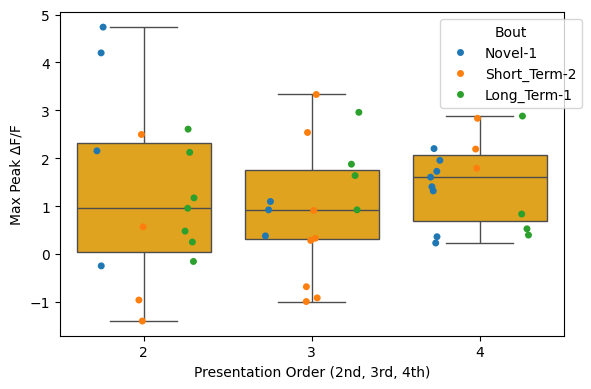

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(
    x="Presentation_Order",
    y="Max Peak",
    data=df_ord,
    color=brain_region
)
sns.stripplot(
    x="Presentation_Order",
    y="Max Peak",
    data=df_ord,
    hue="Bout",
    dodge=True,
    jitter=True
)
plt.xlabel("Presentation Order (2nd, 3rd, 4th)")
plt.ylabel("Max Peak ΔF/F")
plt.legend(bbox_to_anchor=(1.05,1), title="Bout")
plt.tight_layout()
plt.show()


### Run anova for order effects in 3 agent experiment: Total Investigation Time

In [20]:
experiment.reset_all_behaviors()
experiment.group_extract_manual_annotations(bout_definitions, first_only=False)
experiment.compute_all_da_metrics(max_bout_duration=4, 
                                  mode='standard')
exp_da_dict = get_trial_dataframes(experiment)
desired_bouts = ['Short_Term-1', 'Novel-1', 'Short_Term-2', 'Long_Term-1']
da_metadata_df = create_da_metrics_first_instance(exp_da_dict, behavior="Investigation", desired_bouts=desired_bouts)

Processing behaviors for p1-240508-084607...
Processing behaviors for p2-240508-101128...
Processing behaviors for p3-240509-070801...
Processing behaviors for p5-240823-093250...
Processing behaviors for p6-240823-105552...
Processing behaviors for p7-240824-053845...
Processing behaviors for p8-240824-070451...
Processing behaviors for pp1-250120-094415...
Processing behaviors for pp2-250121-123301...
Processing behaviors for pp3-250121-055222...
Processing behaviors for pp4-250121-065035...
Processing behaviors for pp5-250121-110144...
Processing behaviors for pp6-250121-114116...
Processing behaviors for pp7-250121-134131...
Processing behaviors for pp8-250121-142227...
Computing DA metrics for p1-240508-084607 ...
Computing DA metrics for p2-240508-101128 ...
Computing DA metrics for p3-240509-070801 ...
Computing DA metrics for p5-240823-093250 ...
Computing DA metrics for p6-240823-105552 ...
Computing DA metrics for p7-240824-053845 ...
Computing DA metrics for p8-240824-070451

In [21]:
# Step 1: Get trial data
trial_data = get_trial_dataframes(experiment)

# Step 2: Trim Short_Term-1 to first 5 minutes
trimmed_data = trim_short_term_to_5min(trial_data)

# Step 3: Create metadata dataframe with trimmed data
metadata_df = create_metadata_dataframe(trimmed_data, behavior="Investigation")
metadata_df.head()

,Subject,Bout,Behavior,Total Investigation Time,Average Bout Duration
0,p1,Long_Term-1,Investigation,31.599,2.257071
1,p1,Novel-1,Investigation,25.534,2.127833
2,p1,Short_Term-2,Investigation,33.001,3.666778
3,p1,Short_Term-1,Investigation,76.400,4.021053
4,p2,Long_Term-1,Investigation,60.931,3.046550


In [22]:
order_map = assign_bout_order(exp_da_dict, desired_bouts)
metadata_df = add_order_column(metadata_df, order_map)

In [29]:
metadata_df

,Subject,Bout,Behavior,Total Investigation Time,Average Bout Duration,Presentation_Order
0,p1,Long_Term-1,Investigation,31.599,2.257071,4
1,p1,Novel-1,Investigation,25.534,2.127833,2
2,p1,Short_Term-2,Investigation,33.001,3.666778,3
3,p1,Short_Term-1,Investigation,76.400,4.021053,1
4,p2,Long_Term-1,Investigation,60.931,3.046550,3
5,p2,Novel-1,Investigation,36.932,5.276000,4
6,p2,Short_Term-2,Investigation,14.729,1.472900,2
7,p2,Short_Term-1,Investigation,41.129,4.112900,1
8,p3,Long_Term-1,Investigation,34.001,2.428643,2
9,p3,Novel-1,Investigation,21.468,3.066857,4


In [23]:
# assume da_metadata_df already has Presentation_Order
df_ord = metadata_df[metadata_df["Bout"] != "Short_Term-1"].copy()


In [24]:
df_ord.head()

,Subject,Bout,Behavior,Total Investigation Time,Average Bout Duration,Presentation_Order
0,p1,Long_Term-1,Investigation,31.599,2.257071,4
1,p1,Novel-1,Investigation,25.534,2.127833,2
2,p1,Short_Term-2,Investigation,33.001,3.666778,3
4,p2,Long_Term-1,Investigation,60.931,3.046550,3
5,p2,Novel-1,Investigation,36.932,5.276000,4


In [25]:
import pingouin as pg

aov = pg.rm_anova(
    data=df_ord,
    dv="Total Investigation Time",
    within="Presentation_Order",
    subject="Subject",
    detailed=True
)
print(aov)


               Source            SS  DF          MS         F     p-unc  \
0  Presentation_Order   1475.208741   2  737.604371  1.242531  0.304084   
1               Error  16621.655586  28  593.630557       NaN       NaN   

        ng2       eps  
0  0.052781  0.948568  
1       NaN       NaN  


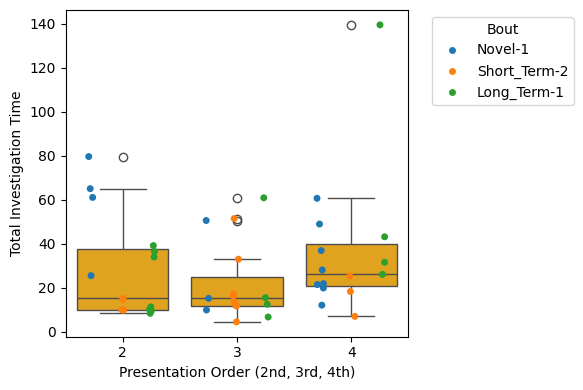

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(
    x="Presentation_Order",
    y="Total Investigation Time",
    data=df_ord,
    color=brain_region
)
sns.stripplot(
    x="Presentation_Order",
    y="Total Investigation Time",
    data=df_ord,
    hue="Bout",
    dodge=True,
    jitter=True
)
plt.xlabel("Presentation Order (2nd, 3rd, 4th)")
plt.ylabel("Total Investigation Time")
plt.legend(bbox_to_anchor=(1.05,1), title="Bout")
plt.tight_layout()
plt.show()


In [27]:
import pingouin as pg

aov = pg.rm_anova(
    data=df_ord,
    dv="Average Bout Duration",
    within="Presentation_Order",
    subject="Subject",
    detailed=True
)
print(aov)


               Source          SS  DF        MS         F     p-unc  \
0  Presentation_Order   15.208159   2  7.604079  1.224596  0.309137   
1               Error  173.864826  28  6.209458       NaN       NaN   

   p-GG-corr       ng2       eps sphericity   W-spher   p-spher  
0   0.301314  0.050832  0.724683      False  0.620086  0.044765  
1        NaN       NaN       NaN        NaN       NaN       NaN  


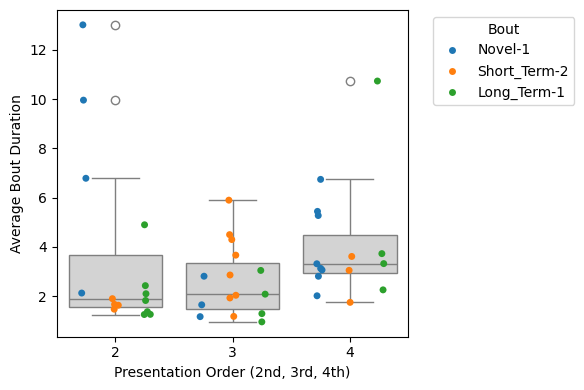

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(
    x="Presentation_Order",
    y="Average Bout Duration",
    data=df_ord,
    color="lightgray"
)
sns.stripplot(
    x="Presentation_Order",
    y="Average Bout Duration",
    data=df_ord,
    hue="Bout",
    dodge=True,
    jitter=True
)
plt.xlabel("Presentation Order (2nd, 3rd, 4th)")
plt.ylabel("Average Bout Duration")
plt.legend(bbox_to_anchor=(1.05,1), title="Bout")
plt.tight_layout()
plt.show()
